Retail Sales Data Analysis

In [160]:
pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
raw_data = pd.read_excel("/Users/pragatipriya/Documents/Python/Online Retail 3.xlsx", engine="openpyxl")

data = raw_data.copy()
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [162]:
print("Number of rows in this data set: ", len(data))
data.info()

Number of rows in this data set:  541909
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [163]:
data["UnitPrice"].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [164]:
data["Quantity"].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

## Managing descrepemcy in Unit Price and Quantity Corelation

In [165]:
data_errors = (data["Quantity"] <=0) & (data["UnitPrice"] <=0)
print("Errors in dataset (qty <=0 & price <=0): ", data_errors.sum())

data_returns = (data["Quantity"] <0) & (data["UnitPrice"] >0)
print("Retunrs in dataset (qty <0 & price>0): ", data_returns.sum())

data_free = (data["Quantity"] >0) & (data["UnitPrice"] ==0)
print("Freebies in dataset (qty >0 & price =0): ", data_free.sum())

Errors in dataset (qty <=0 & price <=0):  1336
Retunrs in dataset (qty <0 & price>0):  9288
Freebies in dataset (qty >0 & price =0):  1179


In [166]:
# Dropping and flagging clean and maintain data integrity

data = data.loc[~data_errors].copy()
data["Isreturn"] = data["Quantity"] <0
data["IsFreeItem"] = data["UnitPrice"] <=0
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Isreturn,IsFreeItem
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False


## Feature Engineering

In [167]:
data["TotalSales"] = data["Quantity"] * data["UnitPrice"]

data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"], errors="coerce")
data["Year"] = data["InvoiceDate"].dt.year # creating year feature
data["Month"] = data["InvoiceDate"].dt.month
data["MonthName"] = pd.Categorical( data["InvoiceDate"].dt.strftime("%b"),
                                   categories=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"], 
                                   ordered=True)

data["MonthofYear"] = data["InvoiceDate"].dt.to_period("M") # for month on month analysis, keeping month and year together
data["QuarterNum"] = data["InvoiceDate"].dt.quarter
data["Quarter"] = data["InvoiceDate"].dt.to_period("Q")


In [168]:
# KPIs
total_rows = len(data)
total_revenue = data.loc[~data["Isreturn"], "TotalSales"].sum()
total_returns = -data.loc[data["Isreturn"], "TotalSales"].sum()
net_revenue = total_revenue - total_returns

print(
    "Rows after cleaning: ", total_rows,
    "\nGross Sales: ", round(total_revenue, 2),
    "\nTotal Returns Value: ", round(total_returns, 2),
    "\nReturn Rate %:", round(100 * data["Isreturn"].mean(), 2),
    "\nNet Revenue: ", round(net_revenue,2)
)

Rows after cleaning:  540573 
Gross Sales:  10644560.42 
Total Returns Value:  896812.49 
Return Rate %: 1.72 
Net Revenue:  9747747.93


## Visualisation

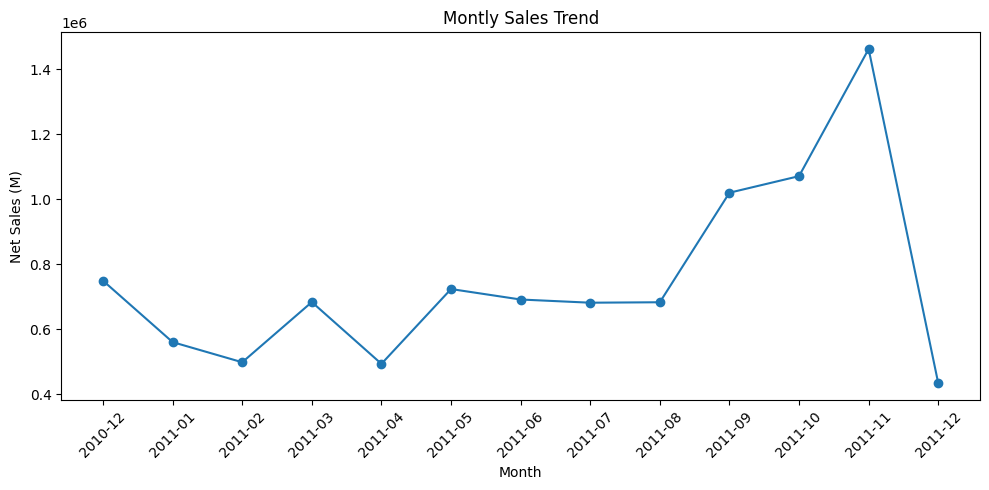

In [169]:
# Monthly Trend 
monthly_sales = data.groupby("MonthofYear", as_index=False)["TotalSales"].sum()
yearly_sales = data.groupby("Year", as_index=False)["TotalSales"].sum()

plt.figure(figsize=(10,5))
plt.plot(monthly_sales["MonthofYear"].astype(str), monthly_sales["TotalSales"], marker = 'o')
plt.xticks(rotation=45)
plt.title("Montly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Net Sales (M)")
plt.tight_layout()
plt.show()


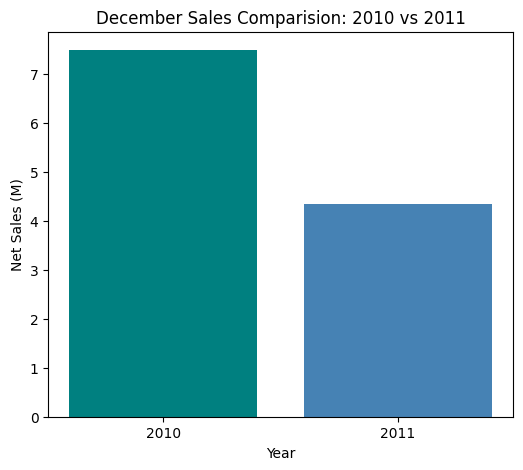

In [185]:
# Dec Sales comparision
dec_sales = data[data["InvoiceDate"].dt.month == 12].copy()
dec_sales["Year"] = dec_sales["InvoiceDate"].dt.year
dec_sales = dec_sales.groupby(dec_sales["Year"],as_index=False)["TotalSales"].sum()

plt.figure(figsize=(6,5))
plt.bar(dec_sales["Year"].astype(str), dec_sales["TotalSales"]/100000, color=["teal", "steelblue"])
plt.title("December Sales Comparision: 2010 vs 2011")
plt.xlabel("Year")
plt.ylabel("Net Sales (M)")
plt.show()

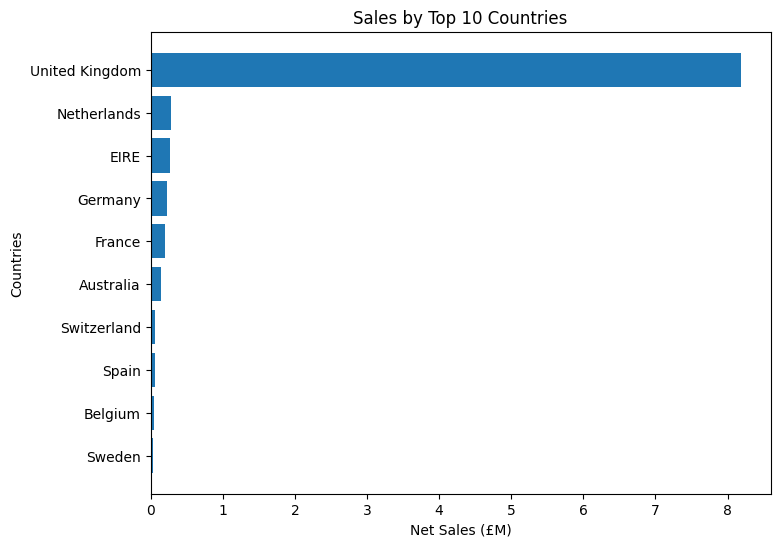

In [171]:
# Revenue by country
country_sales = data.groupby("Country", as_index=False)["TotalSales"].sum().sort_values(
    "TotalSales", ascending=False).head(10)
plt.figure(figsize=(8,6))
plt.barh(country_sales["Country"][::-1], country_sales["TotalSales"][::-1]/1000000)
plt.title("Sales by Top 10 Countries")
plt.xlabel("Net Sales (£M)")
plt.ylabel("Countries")
plt.show()

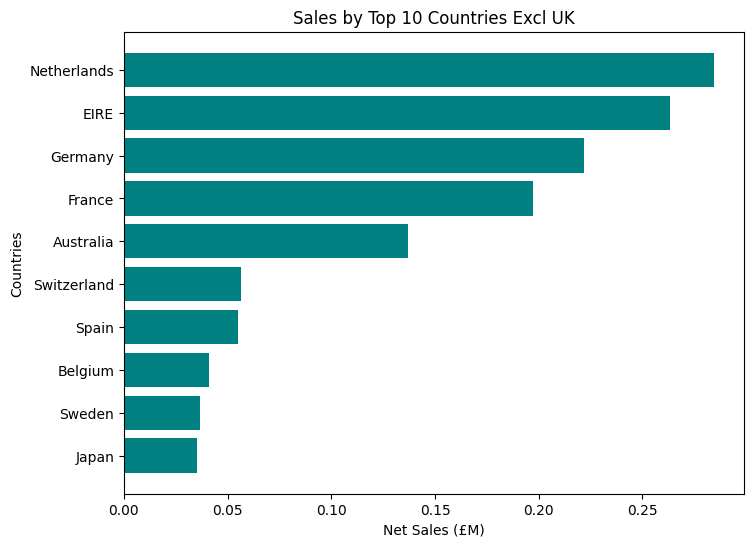

In [172]:
# Revenue by country EXCL UK
country_sales = data.groupby("Country", as_index=False)["TotalSales"].sum().sort_values(
    "TotalSales", ascending=False).query("Country !='United Kingdom'").head(10)
plt.figure(figsize=(8,6))
plt.barh(country_sales["Country"][::-1], country_sales["TotalSales"][::-1]/1000000, color="teal")
plt.title("Sales by Top 10 Countries Excl UK")
plt.xlabel("Net Sales (£M)")
plt.ylabel("Countries")
plt.show()

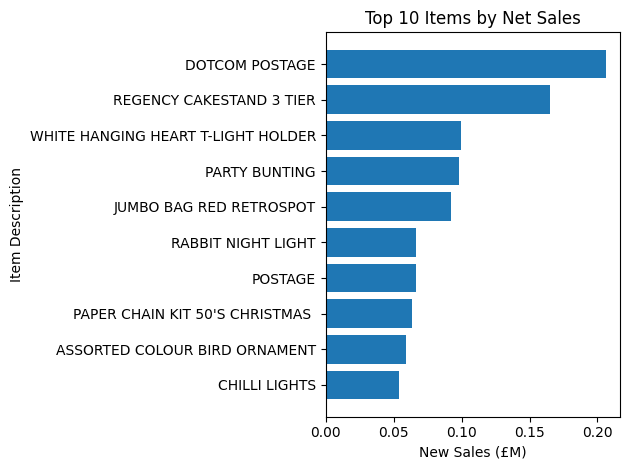

In [173]:
# Top 10 Products by Sales
top_items = data.groupby("Description", as_index=False)["TotalSales"].sum().sort_values("TotalSales", ascending=False).head(10)

plt.barh(top_items["Description"][::-1], top_items["TotalSales"][::-1]/1000000)
plt.title("Top 10 Items by Net Sales")
plt.xlabel("New Sales (£M)")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()

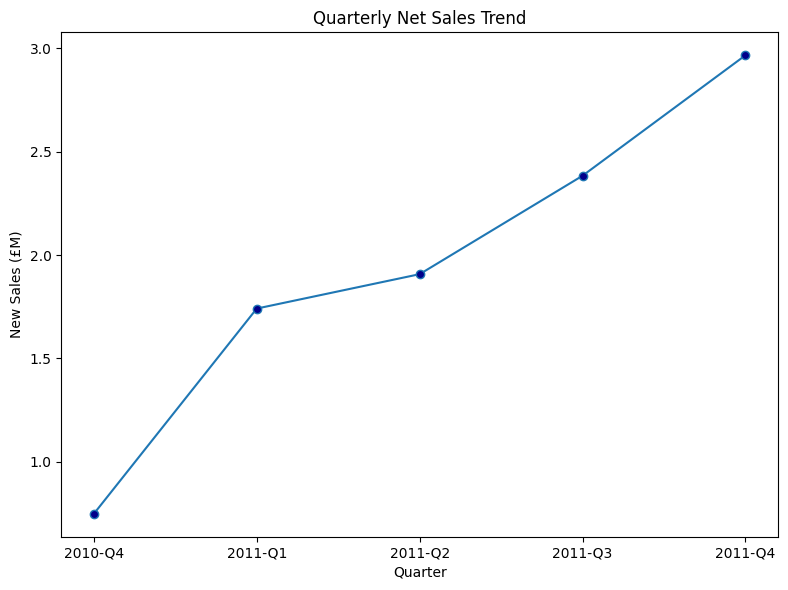

In [174]:
# Qaurterly sales trend 
quarterly_sales = data.groupby(["Year","QuarterNum"], as_index=False)["TotalSales"].sum().sort_values(["Year", "QuarterNum"])
quarterly_sales["YearQuarter"] = (quarterly_sales["Year"].astype(str)+"-Q"+quarterly_sales["QuarterNum"].astype(str))
plt.figure(figsize=(8,6))
plt.plot(quarterly_sales["YearQuarter"], quarterly_sales["TotalSales"]/1000000, marker="o", markerfacecolor="darkblue")
plt.title("Quarterly Net Sales Trend")
plt.xlabel("Quarter")
plt.ylabel("New Sales (£M)")
plt.tight_layout()
plt.show()

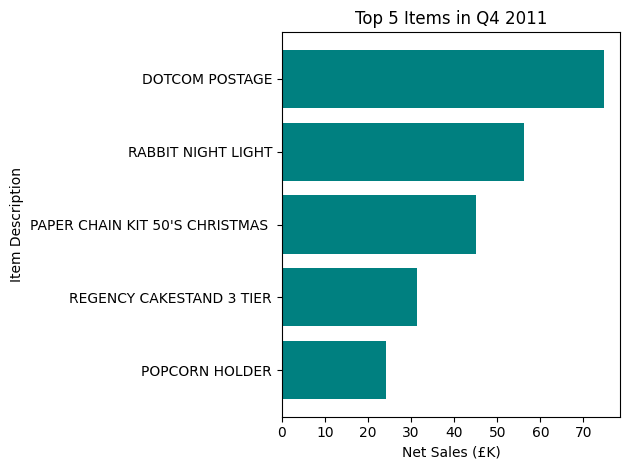

In [184]:
# top items of the best perfoming quarter 
q4_2011 = data[(data["Year"]==2011) & (data["QuarterNum"]==4)]
top_items_q4 = q4_2011.groupby("Description", as_index=False)["TotalSales"].sum().sort_values("TotalSales", ascending=False).head(5)

plt.barh(top_items_q4["Description"][::-1], top_items_q4["TotalSales"][::-1]/1000, color="teal")
plt.title("Top 5 Items in Q4 2011")
plt.xlabel("Net Sales (£K)")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()

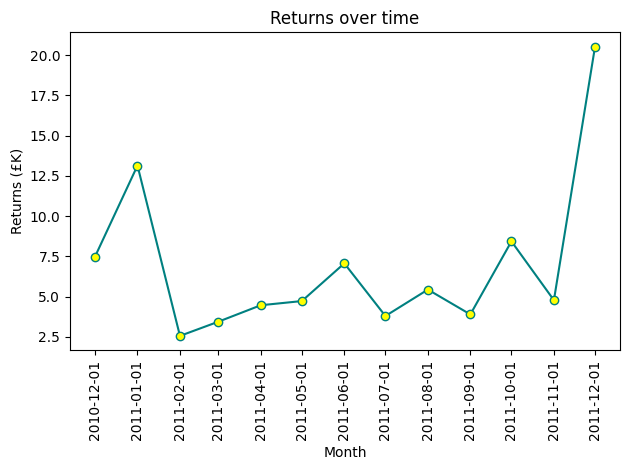

In [176]:
# Retunrs over time
returns = data[data["Isreturn"]]
returns_trend = returns.groupby(["MonthofYear", "Isreturn"], as_index=False)["TotalSales"].sum()
returns_trend["Month"] = returns_trend["MonthofYear"].dt.to_timestamp()

plt.plot(returns_trend["Month"], returns_trend["TotalSales"].abs()/10000, color="teal", marker="o", markerfacecolor="yellow")
plt.title("Returns over time")
plt.xlabel("Month")
plt.ylabel("Returns (£K)")
plt.xticks(returns_trend["Month"], rotation=90)
plt.tight_layout()
plt.show()

In [177]:
# Returns rate by country

country_returns = data[data["Isreturn"]].groupby("Country", as_index=False)["TotalSales"].sum()
country_summary = country_sales.merge(
    country_returns, on="Country", 
    how="left", 
    suffixes=("_sales", "_returns"))

country_summary["TotalSales_returns"] = country_summary["TotalSales_returns"].fillna(0).abs()

country_summary["ReturnsRate"] = (country_summary["TotalSales_returns"]
                                   / country_summary["TotalSales_sales"])*100
print(country_summary.columns)

Index(['Country', 'TotalSales_sales', 'TotalSales_returns', 'ReturnsRate'], dtype='object')


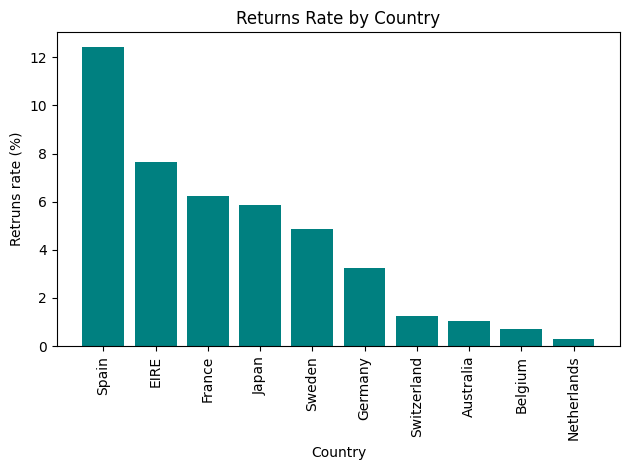

In [178]:
# Top 10 countries by return
top_returns = country_summary.sort_values(
    "ReturnsRate", ascending=False).query(
        "TotalSales_returns >0").head(10)

plt.bar(top_returns["Country"], top_returns["ReturnsRate"], color="teal")
plt.title("Returns Rate by Country")
plt.xlabel("Country")
plt.ylabel("Retruns rate (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

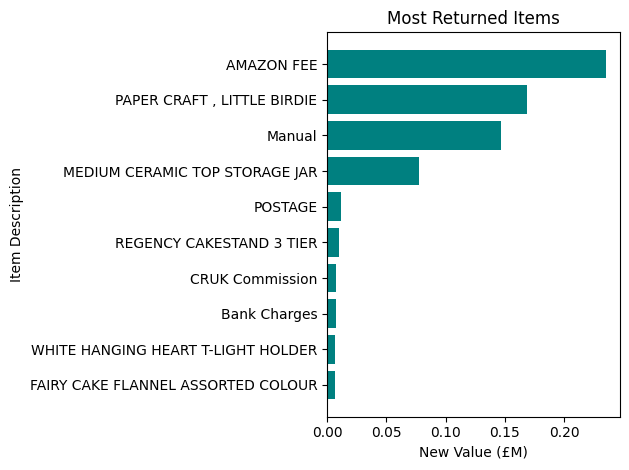

In [ ]:
# Top 10 Products by Sales

item_returns = data.loc[data["Isreturn"]].groupby("Description", as_index=False)["TotalSales"].sum()
item_returns["Return_value"] = item_returns["TotalSales"].abs()
top_item_returns = item_returns.sort_values(
        "Return_value", ascending=False).head(10)

plt.barh(top_item_returns["Description"][::-1],
         top_item_returns["Return_value"][::-1].abs()/1000000, color="teal")
plt.title("Most Returned Items")
plt.xlabel("New Value (£M)")
plt.ylabel("Item Description")
plt.tight_layout()
plt.show()